In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import os
import sys

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.panel_encoder.cnn_embedder import CNNEmbedder
from networks.sort_sequence_network import SortSequenceNetwork
from training.sort_sequence_trainer import SortSequenceTrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

In [6]:
ptu.set_gpu_mode(True)
config = read_config(Config.SORT_SEQUENCE)
golden_age_config = read_config(Config.GOLDEN_AGE)

In [7]:
panel_dim = golden_age_config.panel_dim[0]
cnn_embedder = CNNEmbedder("efficientnet-b5", embed_dim=config.embed_dim)
net = SortSequenceNetwork(embedder=cnn_embedder,
                              num_elements_in_sequence=config.seq_size,
                              pairwise_extraction_in_size=(panel_dim ** 2) * 4).cuda()
    
if getattr(config, 'parallel', False):
    net = nn.DataParallel(net)
        
load_path = "/scratch/users/gsoykan20/projects/AF-GAN/playground/sort_sequence/ckpts/sort_sequence_10-06-2021-16-04-30-checkpoint-epoch3.pth"
net.load_state_dict(torch.load(load_path)['model_state_dict'])

if getattr(config, 'parallel', False):
    print("paralled true")
    net = net.module

net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [8]:
dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                               golden_age_config.sequence_path,
                               golden_age_config.panel_dim,
                               config.image_dim,
                               augment=False,
                               mask_val=False,
                               mask_all=False,
                               return_mask=False,
                               return_gt_last_panel=True,
                               train_test_ratio=golden_age_config.train_test_ratio,
                               train_mode=False,
                               limit_size=-1)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
dl_iter = iter(data_loader)

In [9]:
def plot_panels(panels_tensor):    
    panels = []
    for i in range(panels_tensor.shape[1]):
        panels.append(get_PIL_image(panels_tensor[0,i,:,:,:]))
    
    w, h = panels[0].size
    wsize, hsize =  panels_tensor.shape[1], 1
    w = (w + 100) * wsize
    h = (h + 50) * hsize
    
    px = 1/plt.rcParams['figure.dpi']
    f, ax = plt.subplots(hsize, wsize)
    f.set_size_inches(w*px, h*px)
    
    for i in range(len(panels)):
        ax[i].imshow(panels[i])
        ax[i].title.set_text("Panel" + str(i+1))
        
    plt.show()
    return plt

# Model Result Test

In [10]:
print(net.order_choices)

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


/kuacc/users/gsoykan20/.conda/envs/ulad/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


tensor([[0.1233, 0.1571, 0.1500, 0.1325, 0.2007, 0.2363]], device='cuda:0')
[INFO] Example: 0


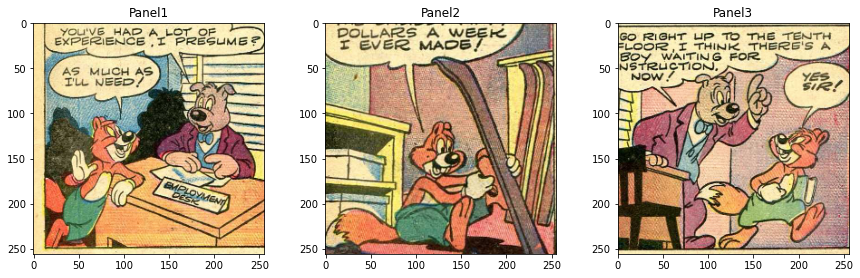

PRED: 5 (2, 1, 0)
GT: 1 (0, 2, 1)
tensor([[0.1420, 0.1530, 0.1659, 0.1501, 0.1842, 0.2047]], device='cuda:0')
[INFO] Example: 1


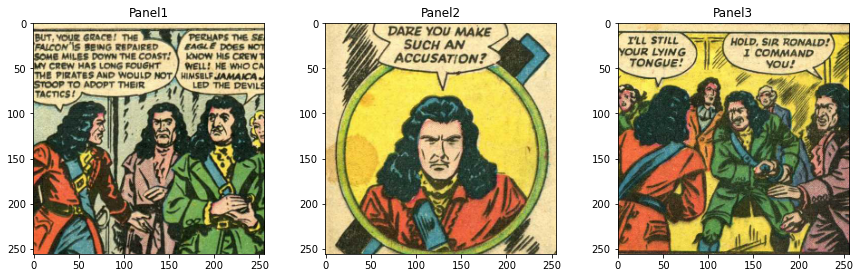

PRED: 5 (2, 1, 0)
GT: 4 (2, 0, 1)
tensor([[0.1661, 0.1495, 0.2027, 0.0997, 0.1787, 0.2032]], device='cuda:0')
[INFO] Example: 2


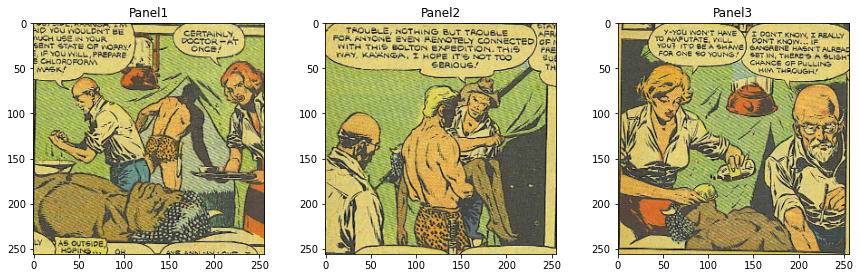

PRED: 5 (2, 1, 0)
GT: 2 (1, 0, 2)
tensor([[0.1531, 0.1431, 0.2255, 0.1041, 0.1757, 0.1983]], device='cuda:0')
[INFO] Example: 3


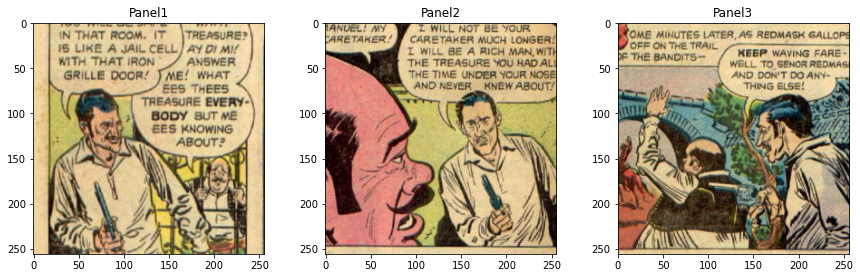

PRED: 2 (1, 0, 2)
GT: 5 (2, 1, 0)
tensor([[0.1997, 0.1445, 0.2275, 0.0860, 0.1885, 0.1538]], device='cuda:0')
[INFO] Example: 4


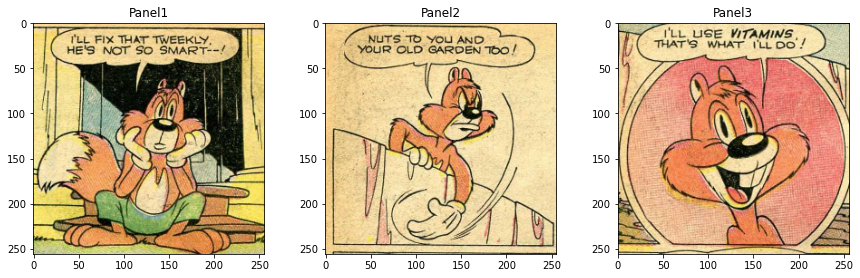

PRED: 2 (1, 0, 2)
GT: 2 (1, 0, 2)
tensor([[0.2315, 0.1592, 0.1681, 0.1183, 0.1510, 0.1720]], device='cuda:0')
[INFO] Example: 5


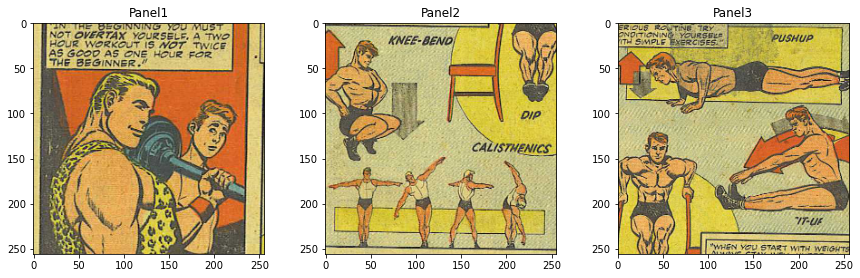

PRED: 0 (0, 1, 2)
GT: 1 (0, 2, 1)


In [13]:
ctr, limit = 0, 6
softmax = nn.Softmax()

for i in range(limit):
    x, _, gt = next(dl_iter)
    
    with torch.no_grad():
        x = x.cuda()
        gt = gt.cuda()
        x[:, -1] = gt
        output, labels = net.shuffle_forward(x)
        softed = softmax(output)
        print(softed)
        pred = torch.argmax(softed, dim=1)
    print("[INFO] Example:", i)
    plot_panels(x)
    pred_label = (pred.detach().cpu().numpy()[0])
    print("PRED: " + str(pred_label) + " " + str(net.order_choices[pred_label]))
    gt_label = labels.detach().cpu().numpy()[0]
    print("GT: " +  str(gt_label) + " " + str(net.order_choices[gt_label]))